In [6]:
import collections
import os
import sys
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import datetime
from IPython import display
from openvino.runtime import Core
sys.path.append("../utils")
import notebook_utils as utils
import easyocr
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [7]:

converted_model_path = f"model/vehicle-license-plate-detection-barrier-0123/FP32/vehicle-license-plate-detection-barrier-0123.xml"

classes = ['','car','plate']
# Initialize OpenVINO Runtime.
ie_core = Core()
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
#height, width = list(input_layer.shape)[1:3]
height, width=256,256

plate_list= []

now = datetime.datetime.now()
today_date = now.strftime("%Y-%m-%d")

In [12]:
# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()

def draw_boxes(frame, boxes):
    for label, score, x_min, y_min, x_max, y_max in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = x_min + x_max
        y2 = y_min + y_max
        cv2.rectangle(img=frame, pt1=(x_min,y_min), pt2=(x_max, y_max), color=color, thickness=3)
        
        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(x_min + 10, y_min + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        ) 

    return frame

#function to return most length in a list, and then only choose for most frequent
def most_frequent_longest_string(str_list):
    # Initialize a dictionary to store the frequency of each string
    freq_dict = {}
    # Loop through each string in the list
    for string in str_list:
        # If the string is already in the frequency dictionary, increment its count
        if string in freq_dict:
            freq_dict[string] += 1
        # Otherwise, add it to the frequency dictionary with a count of 1
        else:
            freq_dict[string] = 1

    # If the frequency dictionary is empty, return None
    if not freq_dict:
        return None

    # Initialize variables to store the longest and most frequent strings
    longest_string = ""
    max_frequency = 0
    max_length = 0
    frequent_longest_strings = []
    # Loop through each string in the frequency dictionary
    for string, frequency in freq_dict.items():
        # If the current string is longer than the current longest string, update the longest string and max length
        if len(string) > len(longest_string):
            longest_string = string
            max_length = len(longest_string)
            max_frequency = frequency
            frequent_longest_strings = [longest_string]
        # If the current string has the same length as the current longest string and a higher frequency, update the max frequency and add the string to the list of frequent longest strings
        elif len(string) == len(longest_string) and frequency == max_frequency:
            frequent_longest_strings.append(string)
        # If the current string has the same length as the current longest string and a higher frequency, update the max frequency and reset the list of frequent longest strings with the current string
        elif len(string) == len(longest_string) and frequency > max_frequency:
            max_frequency = frequency
            frequent_longest_strings = [string]

    # Return the list of frequent longest strings
    return frequent_longest_strings


def retrieve_coordinate(bgr_image, resized_image, boxes, threshold=0.3) -> np.ndarray:
    """
    Use bounding boxes from detection model to find the absolute car position [1] label position [2]
    
    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: car_position: car's absolute position
    """
    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y
    
    # Find the boxes ratio
    boxes = boxes[:, 1:]

    # Store the vehicle's position
    position = []
    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image, 
            # we position upper box bar little bit lower to make it visible on image 
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y * resized_y, 10)) if idx % 2 
                else int(corner_position * ratio_x * resized_x)
                for idx, corner_position in enumerate(box[2:])
            ]
            position.append([int(box[0]),conf,x_min, y_min, x_max, y_max])         
    return position

def save_result_to_txt(plate_no):
    if not plate_no:
        return
    else:
        now = datetime.datetime.now()
        date_string = now.strftime("%Y-%m-%d %H:%M:%S")
        with open(f'{today_date} report.txt', "a") as f:
            f.write(plate_no + "\tTime: " + date_string + "\n")

def save_plate_image(img, plate_pos):
    # Select a vehicle to recognize.
    pos = plate_pos[0]
    # Crop the image with [y_min:y_max, x_min:x_max].
    test_car = img[pos[3]:pos[5], pos[2]:pos[4]]
    #test_car = img[pos[1]:pos[3], pos[0]:pos[2]]

    # Resize the image to input_size.
    if test_car.size == 0:
        return
    resized_image_re = cv2.resize(test_car, (pos[4]-pos[2], pos[5]-pos[3]))
    #plt_show(cv2.cvtColor(resized_image_re, cv2.COLOR_BGR2RGB))
    cv2.imwrite("temp_plate.jpg", resized_image_re)
    result0= reader.readtext("temp_plate.jpg")
    
    if not result0:   #return nothing while not detect the words from image
        plate_list.append('')
        return
    else:
        #save all carplate to plate_list, and save to txt file
        if(result0[0][2] > 0.8): #check if the word ocr conf >0.6
            result = np.array(result0,dtype=object)
            # Create an empty list to store the middle numbers
            plate_no = []
            # Loop through the rows of the array
            for index, val in enumerate(result):
                if result[index][2] <= 0.9:
                    continue
                # Get the middle number of each row
                middle_number = val[len(val) // 2]
                # Append the middle number to the list
                plate_no.append(middle_number)
            # Convert the list of numbers to a single string
            plate_no = " ".join(str(x) for x in plate_no)
            plate_no = plate_no.replace(" ", "")
            
            #further process the result if only detected plate number length > 3
            if len(plate_no) > 3:
                plate_list.append(plate_no) # append carplate to plate_list
                #save to txt file if only plate_list> 20
                if len(plate_list) >30 :
                    predicted_number = most_frequent_longest_string(plate_list)
                    for plate_number in predicted_number:
                        save_result_to_txt(plate_number)
                         
                    plate_list.clear()
            else:
                plate_list.append('')
                return
            
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    width, height = 256,256
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1440 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            resized_image = input_img
            
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]
            
            # Measure processing time.
            start_time = time.time()
            
            # Get the results.
            boxes = compiled_model([input_img])[output_layer]
            
            # process result
            # Delete the dim of 0, 1.
            boxes = np.squeeze(boxes,(0,1))
            
            # Remove zero only boxes.
            boxes = boxes[~np.all(boxes ==0, axis=1)]
            
            #seperate label object
            if boxes is None:
                car_pos = []
                plate_pos = []
            else:
                if len(boxes) == 0:
                    car_pos = []
                    plate_pos = []
                else:
                    car_pos = boxes[boxes[:, 1] == 1]
                    plate_pos = boxes[boxes[:, 1] == 2]

            frame_ori=frame.copy()
            car_pos=retrieve_coordinate(frame,resized_image,car_pos,threshold=0.3)   
            plate_pos=retrieve_coordinate(frame,resized_image,plate_pos,threshold=0.3)   
            
            #if both have not empty list
            # Draw boxes on a frame.
            if(((not car_pos) | (not plate_pos)) == 0):   
                frame = draw_boxes(frame=frame, boxes=plate_pos)
                frame = draw_boxes(frame=frame, boxes=car_pos)
                save_plate_image(frame_ori,plate_pos)
            else:
                #insert empty string to list every frame
                plate_list.append("")
            
            #clear and save every 15 frame
            if len(plate_list) > 30:
                predicted_number = most_frequent_longest_string(plate_list)
                for plate_number in predicted_number:
                    save_result_to_txt(plate_number)
                plate_list.clear()
                
            stop_time = time.time()
            
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()
            
            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            
            #print('fps',fps)
            
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            #Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()


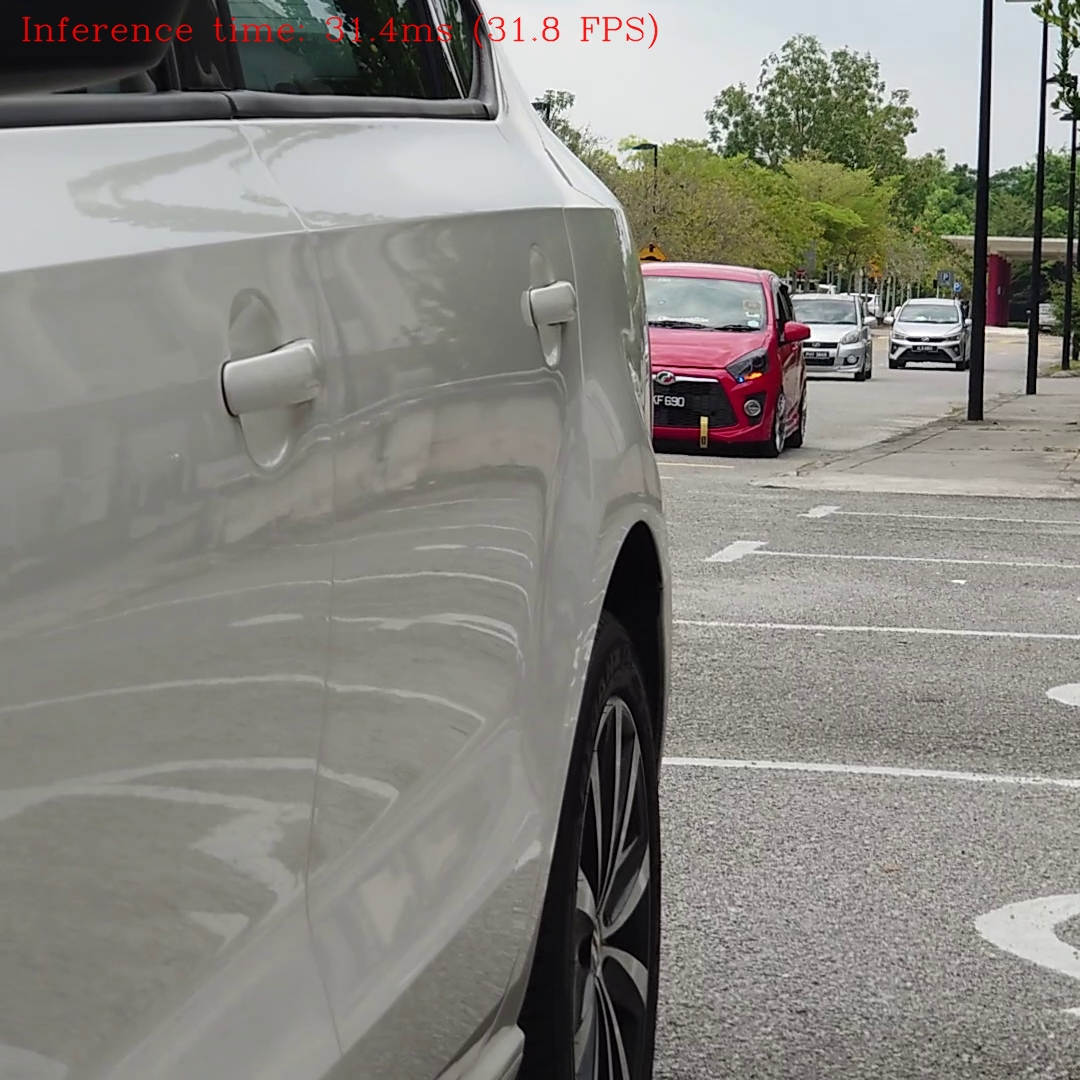

Source ended


In [13]:
run_object_detection(source="images/front4.mp4", flip=False, use_popup=False)